# GAN for Domain Adaptation Implementation

Based on the paper: <i>Unsupervised Pixel–Level Domain Adaptation with Generative Adversarial Networks</i>, but without the content loss. The PatchGAN discriminator variation is referenced from: <i>Image-to-Image Translation with Conditional Adversarial Networks</i>. The task here is to utilize the standard MNIST data to predict the labels for an alternative MNIST dataset in which each digit has a non-black background. There is a reference implementation [here](https://github.com/eriklindernoren/Keras-GAN/blob/master/pixelda/pixelda.py) and [here](https://github.com/eriklindernoren/PyTorch-GAN/blob/master/implementations/pixelda/pixelda.py).

In [1]:
import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Input,Dense,Reshape,Dropout,BatchNormalization,Activation,UpSampling2D,Embedding
from tensorflow.keras.layers import BatchNormalization,Conv2D,LeakyReLU,Flatten,Conv2DTranspose,Concatenate
from tensorflow.keras.optimizers import Adam,RMSprop
from tensorflow.keras.models import Model,Sequential
from tensorflow.keras.losses import BinaryCrossentropy,SparseCategoricalCrossentropy,MeanSquaredError
import numpy as np
from sklearn.utils import shuffle
from sklearn.metrics import accuracy_score,balanced_accuracy_score
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
tf.keras.backend.set_floatx('float32')

import warnings
warnings.filterwarnings('ignore')

## Data Cleaning

In [2]:
# MNIST data with background:
mnist_w_background_x = np.load("../data/mnist/mnist_with_background_x.npy") # already scaled by 255
mnist_w_background_y = np.squeeze(np.load("../data/mnist/mnist_with_background_y.npy"))
mnist_w_background_x = mnist_w_background_x[mnist_w_background_y <= 3]
mnist_w_background_y = mnist_w_background_y[mnist_w_background_y <= 3]
mnist_w_background_x = np.reshape(mnist_w_background_x,(len(mnist_w_background_x),28,28),order="F")
mnist_w_background_x = ((mnist_w_background_x*255)-127.5)/127.5 # scaling for tanh activation
mnist_w_background_y = np.expand_dims(mnist_w_background_y,axis=-1)
mnist_w_background_x = np.expand_dims(mnist_w_background_x,axis=-1)
mnist_w_background_x = mnist_w_background_x[:25600]
mnist_w_background_y = mnist_w_background_y[:25600]
print(mnist_w_background_x.shape,mnist_w_background_y.shape)

(25600, 28, 28, 1) (25600, 1)


In [3]:
# Standard MNIST data:
(x_train, y_train),(x_test, y_test) = tf.keras.datasets.mnist.load_data()
#x_train = np.vstack([x_train,x_test])
#y_train = np.concatenate([y_train,y_test])
x_train = x_train.astype('float32')
y_train = y_train.astype('float32')
x_train = x_train[y_train <= 3] # using numbers 0,1,2,3
y_train = y_train[y_train <= 3]
x_train = (x_train-127.5)/127.5 # scaling the images for tanh activation
y_train = y_train.astype("int32")
y_train = np.expand_dims(y_train,axis=-1)
x_train = np.expand_dims(x_train,axis=-1)
x_train = x_train[:24750] #28900]
y_train = y_train[:24750] #28900]
print(x_train.shape,y_train.shape)

(24750, 28, 28, 1) (24750, 1)


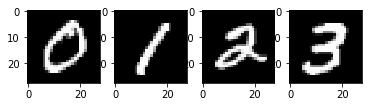

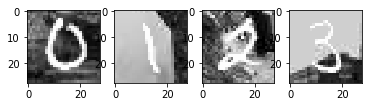

In [4]:
# Plotting comparisons between the two datasets:
plt.subplot(1,4,1)
plt.imshow(np.squeeze(x_train[0]),cmap="gray")
plt.subplot(1,4,2)
plt.imshow(np.squeeze(x_train[1]),cmap="gray")
plt.subplot(1,4,3)
plt.imshow(np.squeeze(x_train[2]),cmap="gray")
plt.subplot(1,4,4)
plt.imshow(np.squeeze(x_train[4]),cmap="gray")
plt.show()

plt.subplot(1,4,1)
plt.imshow(np.squeeze(mnist_w_background_x[44]),cmap="gray")
plt.subplot(1,4,2)
plt.imshow(np.squeeze(mnist_w_background_x[46]),cmap="gray")
plt.subplot(1,4,3)
plt.imshow(np.squeeze(mnist_w_background_x[47]),cmap="gray")
plt.subplot(1,4,4)
plt.imshow(np.squeeze(mnist_w_background_x[45]),cmap="gray")
plt.show()

## Domain Adaptation Model Implementation

-discriminator and task_models are trained independently; generator model is trained by being part of a system connected to the discriminator and task_models.

In [5]:
def generator_residual_block(source_h):
    """ defines the residual block for the generator implementation
    """
    h = Conv2D(filters=64,kernel_size=3,strides=1,padding='same',activation=None)(source_h)
    h = BatchNormalization(momentum=0.8)(h)
    h = Activation('relu')(h)
    h = Conv2D(filters=64,kernel_size=3,strides=1,padding='same',activation=None)(h)
    h = BatchNormalization(momentum=0.8)(h)
    h = h+source_h
    return h

In [6]:
def get_generator(noise_dim=100,num_resid_blocks=3):
    """ generator implementation
    """
    z = Input(shape=(noise_dim))
    source_image = Input(shape=(28,28,1))
    
    z_h = Dense(28*28*2,activation=None)(z)
    z_h = Reshape((28,28,2))(z_h)

    source_h = Concatenate()([z_h,source_image])
    source_h = Conv2D(filters=64,kernel_size=3,strides=1,padding='same',activation=None)(source_h)
    h = Activation('relu')(source_h)
    
    for _ in range(num_resid_blocks):
        h = generator_residual_block(h)
        
    h = Conv2D(filters=1,kernel_size=3,strides=1,padding='same',activation=None)(h)
    h = Activation('tanh')(h)
    
    model = Model(inputs=[z,source_image],outputs=h)
    return model

In [7]:
def discriminator_block(h,n_channels,n_strides,kernel_size=3,padding='same'):
    """ defines the block for the discriminator implementation
    """
    h = Conv2D(filters=n_channels,kernel_size=kernel_size,strides=n_strides,padding=padding,activation=None)(h)
    h = BatchNormalization()(h)
    h = LeakyReLU(0.2)(h)
    return h

In [8]:
def get_discriminator():
    """ discriminator implementation
    """
    x = Input(shape=(28,28,1))
    h = discriminator_block(x,64,n_strides=1)
    h = discriminator_block(h,128,n_strides=2)
    h = discriminator_block(h,256,n_strides=2)
    h = discriminator_block(h,512,n_strides=2)
    h = discriminator_block(h,1024,n_strides=2)
    h = Flatten()(h)
    h = Dense(1,activation=None)(h)
    ##h = Conv2D(filters=1,kernel_size=3,strides=1,padding='same',activation=None)(h) # patchGAN variation
    
    model = Model(inputs=x,outputs=h)
    return model

In [9]:
def get_task_model(num_classes=4):
    """ task_model implementation
    """
    x = Input(shape=(28,28,1))
    h = Conv2D(filters=32,kernel_size=3,strides=2,padding='same',activation=None)(x)
    h = BatchNormalization()(h)
    h = LeakyReLU(0.2)(h)
    h = Conv2D(filters=64,kernel_size=3,strides=2,padding='same',activation=None)(h)
    h = BatchNormalization()(h)
    h = LeakyReLU(0.2)(h)
    h = Conv2D(filters=128,kernel_size=3,strides=2,padding='same',activation=None)(h)
    h = BatchNormalization()(h)
    h = LeakyReLU(0.2)(h)
    h = Flatten()(h)
    h = Dense(num_classes,activation="softmax")(h) # not using logits
    
    model = Model(inputs=x,outputs=h)
    return model

In [10]:
def compile_model(model,loss,optimizer):
    """ compiles task and discriminator networks
    """
    c_model = Sequential()
    c_model.add(model)
    c_model.compile(loss=loss,optimizer=optimizer)
    return c_model

In [11]:
def compile_adversarial_model(generator,discriminator,task_model,optimizer,noise_dim=100,class_lam=0.9):
    """ compiles model used to train the generator
    """
    z = Input(shape=(noise_dim))
    source_image = Input(shape=(28,28,1))
    gen = generator([z,source_image])
    task_pred = task_model(gen)
    class_pred = discriminator(gen)
    
    model = Model(inputs=[z,source_image],outputs=[task_pred,class_pred])
    model.compile(loss=['sparse_categorical_crossentropy','mean_squared_error'],loss_weights=[1-class_lam,class_lam],optimizer=optimizer)
    return model

In [12]:
discriminator_pre = get_discriminator()
task_model_pre = get_task_model(num_classes=4)
generator = get_generator()

discriminator = compile_model(discriminator_pre,loss="mean_squared_error",optimizer=Adam(lr=0.0002))
task_model = compile_model(task_model_pre,loss="sparse_categorical_crossentropy",optimizer=Adam(lr=0.0002))
adversarial = compile_adversarial_model(generator,discriminator_pre,task_model_pre,optimizer=Adam(lr=0.0002),class_lam=0.9)

### Domain Adaptation Model Training

-noise prior used is ~N(0,1)

In [13]:
num_epochs=100
batch_size=50
for epoch_i in range(num_epochs): # number of epochs
    all_a_losses = []
    all_d_losses = []
    all_t_losses = []
    print("Epoch {}:".format(epoch_i+1))
    
    for i in range(0,len(x_train)-batch_size,batch_size):
        x_subset = x_train[i:i+batch_size] # from the source distribution
        y_subset = y_train[i:i+batch_size]
        target_x_subset = mnist_w_background_x[i:i+batch_size]
        
        # training the discriminator:
        z = np.random.normal(0.0,1.0,size=(batch_size,100))
        x_gen = generator([z,x_subset])
        disc_x = np.vstack((target_x_subset,x_gen))
        disc_y = np.vstack([np.ones((batch_size,1)),np.zeros((batch_size,1))]) #1:real, 0:fake
        discriminator.trainable=True
        d_loss = discriminator.train_on_batch(disc_x,disc_y)
        all_d_losses.append(float(d_loss))
        
        # training the task-model:
        ## paper found that training on adapted, along with non-adapted source images improves stability
        task_x = np.vstack([x_subset,x_gen])
        task_y = np.vstack([y_subset,y_subset])
        task_model.trainable=True
        t_loss = task_model.train_on_batch(task_x,task_y)
        all_t_losses.append(float(t_loss))
        
        # training the generator:
        class_y = np.ones([batch_size,1]) # we switch the labels here to maximize the domain-confusion
        task_y = y_subset
        z = np.random.normal(0.0,1.0,size=(batch_size,100))
        task_model.trainable=False
        discriminator.trainable=False
        a_loss = adversarial.train_on_batch([z,x_subset],[task_y,class_y])
        all_a_losses.append(float(a_loss[0])) # the first index is the weighted sum of both losses
        
        if i%2000 == 0:
            input_subset = x_subset[0:10]
            input_subset.shape = (10,28,28)
            plt.figure(figsize=(15,4))
            for i in range(10): # plotting input images
                plt.subplot(1,10,i+1)
                plt.imshow(input_subset[i],cmap="gray")
            plt.show()
            for _ in range(2):
                z = np.random.normal(0.0,1.0,size=(10,100))
                gen_subset = generator([z,input_subset]).numpy() # output is still scaled
                gen_subset.shape = (10,28,28)
                plt.figure(figsize=(15,4))
                for i in range(10): # plotting generated images
                    plt.subplot(1,10,i+1)
                    plt.imshow(gen_subset[i],cmap="gray")
                plt.show()
            print("-----------------")
                
    a_avg_loss = sum(all_a_losses)/len(all_a_losses)
    d_avg_loss = sum(all_d_losses)/len(all_d_losses)
    t_avg_loss = sum(all_t_losses)/len(all_t_losses)
    print("gen. loss:{}; disc. loss:{}; task loss:{}".format(a_avg_loss,d_avg_loss,t_avg_loss)) 
    print("---------------------------------------------------------------------------------------------------")
    print("---------------------------------------------------------------------------------------------------")
    print("---------------------------------------------------------------------------------------------------")

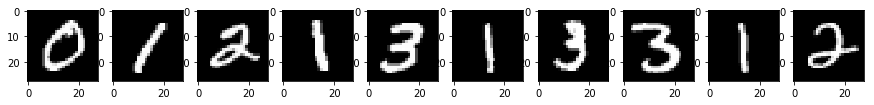

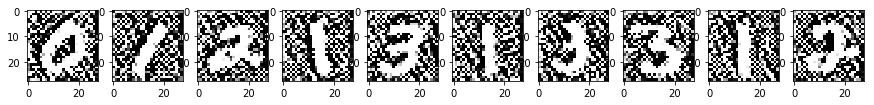

In [16]:
# plotting the output of the generator
## note: model still needs some work in order to improve the output
input_subset = x_train[0:10]
input_subset.shape = (10,28,28)
plt.figure(figsize=(15,4))
for i in range(10): # plotting input images
    plt.subplot(1,10,i+1)
    plt.imshow(input_subset[i],cmap="gray")
plt.show()

z = np.random.normal(0.0,1.0,size=(10,100))
gen_subset = generator([z,input_subset]).numpy() # output is still scaled
gen_subset.shape = (10,28,28)
plt.figure(figsize=(15,4))
for i in range(10): # plotting generated images
    plt.subplot(1,10,i+1)
    plt.imshow(gen_subset[i],cmap="gray")
plt.show()

### Using adapted images for semi-supervised learning

In [17]:
# getting the data for this task
mnist_background_train_x = [] ## getting 1000 examples for the training/test sets
mnist_background_test_x = []
mnist_background_train_y = []
mnist_background_test_y = []

for i in range(0,4):
    this_mnist_subset = mnist_w_background_x[np.squeeze(mnist_w_background_y)==i]
    mnist_background_train_x.append(this_mnist_subset[0:1000])
    mnist_background_test_x.append(this_mnist_subset[1000:2000])
    mnist_background_train_y.append(np.array([i for _ in range(1000)]))
    mnist_background_test_y.append(np.array([i for _ in range(1000)]))

mnist_background_train_x = np.vstack(mnist_background_train_x)
mnist_background_test_x = np.vstack(mnist_background_test_x)
mnist_background_train_y = np.concatenate(mnist_background_train_y)
mnist_background_test_y = np.concatenate(mnist_background_test_y)
mnist_background_train_x,mnist_background_train_y = shuffle(mnist_background_train_x,mnist_background_train_y,random_state=0)
mnist_background_test_x,mnist_background_test_y = shuffle(mnist_background_test_x,mnist_background_test_y,random_state=1)
mnist_background_train_y = np.expand_dims(mnist_background_train_y,axis=-1)
mnist_background_test_y = np.expand_dims(mnist_background_test_y,axis=-1)
print(mnist_background_train_x.shape,mnist_background_train_y.shape,mnist_background_test_x.shape,mnist_background_test_y.shape)

(4000, 28, 28, 1) (4000, 1) (4000, 28, 28, 1) (4000, 1)


In [18]:
def get_model(optimizer,num_classes=4):
    """ model used in the semi-supervised prediction task
    """
    x = Input(shape=(28,28,1))
    h = Conv2D(filters=32,kernel_size=3,strides=2,padding='same',activation=None)(x)
    h = BatchNormalization()(h)
    h = Activation('relu')(h)
    h = Conv2D(filters=64,kernel_size=3,strides=2,padding='same',activation=None)(h)
    h = BatchNormalization()(h)
    h = Activation('relu')(h)
    h = Conv2D(filters=128,kernel_size=3,strides=2,padding='same',activation=None)(h)
    h = BatchNormalization()(h)
    h = Activation('relu')(h)
    h = Flatten()(h)
    h = Dense(num_classes,activation="softmax")(h) # not using logits
    
    model = Model(inputs=x,outputs=h)
    model.compile(loss="sparse_categorical_crossentropy",optimizer=optimizer)
    return model

In [19]:
model = get_model(optimizer=Adam(lr=0.001))

In [20]:
# getting all the transformations
gen_mnist_x_train = []
for i in range(0,len(x_train),50):
    gen_subset = generator([np.random.normal(0.0,1.0,size=(50,100)),x_train[i:i+50]])
    gen_mnist_x_train.append(gen_subset)
gen_mnist_x_train = np.vstack(gen_mnist_x_train)
gen_mnist_x_train.shape

(24750, 28, 28, 1)

In [21]:
final_x_train = np.vstack([mnist_background_train_x,gen_mnist_x_train])
final_y_train = np.vstack([mnist_background_train_y,y_train])
final_x_test = mnist_background_test_x
final_y_test = mnist_background_test_y
print(final_x_train.shape,final_y_train.shape,final_x_test.shape,final_y_test.shape)

(28750, 28, 28, 1) (28750, 1) (4000, 28, 28, 1) (4000, 1)


In [22]:
num_epochs=10
batch_size=25
for epoch_i in range(num_epochs): # number of epochs
    epoch_losses = []
    for i in range(0,len(final_x_train)-batch_size,batch_size):
        x_subset = final_x_train[i:i+batch_size]
        y_subset = final_y_train[i:i+batch_size]
        batch_loss = model.train_on_batch(x_subset,y_subset)
        epoch_losses.append(float(batch_loss))
        
    print("epoch {}; loss:{};".format(epoch_i+1,round(sum(epoch_losses)/len(epoch_losses),4)))
    train_pred = model(final_x_train).numpy()
    test_pred = model(final_x_test).numpy()
    train_pred,test_pred = np.argmax(train_pred,axis=-1),np.argmax(test_pred,axis=-1)
    
    train_acc,train_bal_acc = round(accuracy_score(final_y_train,train_pred),4),round(balanced_accuracy_score(final_y_train,train_pred),4)
    test_acc,test_bal_acc = round(accuracy_score(final_y_test,test_pred),4),round(balanced_accuracy_score(final_y_test,test_pred),4)
    print("-Train; accuracy:{}; bal_accuracy:{}".format(train_acc,train_bal_acc))
    print("-Test; accuracy:{}; bal_accuracy:{}".format(test_acc,test_bal_acc))
    print("--------------------------------------------------")

epoch 1; loss:0.1006;
-Train; accuracy:0.9775; bal_accuracy:0.9774
-Test; accuracy:0.8682; bal_accuracy:0.8682
--------------------------------------------------
epoch 2; loss:0.0477;
-Train; accuracy:0.9879; bal_accuracy:0.9878
-Test; accuracy:0.915; bal_accuracy:0.915
--------------------------------------------------
epoch 3; loss:0.0244;
-Train; accuracy:0.9905; bal_accuracy:0.9906
-Test; accuracy:0.9128; bal_accuracy:0.9128
--------------------------------------------------
epoch 4; loss:0.0205;
-Train; accuracy:0.9883; bal_accuracy:0.9883
-Test; accuracy:0.9088; bal_accuracy:0.9088
--------------------------------------------------
epoch 5; loss:0.0133;
-Train; accuracy:0.99; bal_accuracy:0.9899
-Test; accuracy:0.9195; bal_accuracy:0.9195
--------------------------------------------------
epoch 6; loss:0.0101;
-Train; accuracy:0.9906; bal_accuracy:0.9905
-Test; accuracy:0.9232; bal_accuracy:0.9232
--------------------------------------------------
epoch 7; loss:0.0116;
-Train; ac